In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# For example, here's several helpful packages to load
!pip3 install --upgrade tensorflow
!pip3 install --upgrade tensorflow-probability
!pip install --upgrade "tensorflow-probability[tf]"



import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
# 設定 seaborn 主題，這會影響圖表的風格和顏色
sns.set_theme()  # Apply the default Seaborn theme
%matplotlib inline
# Libraries for statistical and scientific computing
import statsmodels.api as sm
from scipy import stats
from pytorch_lightning.callbacks import EarlyStopping, Callback, ModelCheckpoint
from sklearn.preprocessing import MinMaxScaler, StandardScaler

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [2]:
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions
tfpl = tfp.layers

print('TF version:', tf.__version__)
print('TFP version:', tfp.__version__)

from keras.models import Sequential, Model
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, LSTM, TimeDistributed, ConvLSTM2D, Bidirectional, Input, Concatenate
from keras.losses import SparseCategoricalCrossentropy, BinaryCrossentropy
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

from sklearn.preprocessing import StandardScaler, OneHotEncoder

from pathlib import Path

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

/Users/apple/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


TF version: 2.16.1
TFP version: 0.24.0


In [3]:
# 使用pandas讀取CSV文件
df = pd.read_csv('https://raw.githubusercontent.com/xc90529/noninvasive_data_visualization/main/noninvasive_data.csv')

# To display the top 5 rows
df.head(5)
#CO-心輸出量
#CI - 心輸出指數
#SV - 舒張容積
#SVI - 舒張容積指數
#SVV - 舒張容積變異度
#SVR - 舒張容積阻力
#SVRI - 舒張容積指數阻力
#PR - 脈搏率
#SYS - 收縮壓
#DIA - 舒張壓
#MAP - 平均動脈壓

,si1m,CO,CI,SV,SVI,SVV,SVR,SVRI,PR,SYS,DIA,MAP,ID,time
0,N,4.0,2.4,43,26.0,10,1673.0,2745.0,93,116,74,91,#_1,120.000000
1,N,4.0,2.4,43,26.0,10,1683.0,2760.0,92,118,74,91,#_1,120.333333
2,N,3.6,2.2,39,24.0,17,1978.0,3245.0,92,121,80,97,#_1,120.666667
3,N,3.6,2.2,41,25.0,17,1868.0,3065.0,88,118,76,93,#_1,121.000000
4,N,4.2,2.6,42,26.0,10,1335.0,2190.0,100,100,66,78,#_1,121.333333


In [4]:
# Calculating the Shock Index as PR / SYS
df['PR/SYS'] = df['PR'] / df['SYS']

# Displaying the first few rows of the dataframe to confirm the new variable
df.head()

,si1m,CO,CI,SV,SVI,SVV,SVR,SVRI,PR,SYS,DIA,MAP,ID,time,PR/SYS
0,N,4.0,2.4,43,26.0,10,1673.0,2745.0,93,116,74,91,#_1,120.000000,0.801724
1,N,4.0,2.4,43,26.0,10,1683.0,2760.0,92,118,74,91,#_1,120.333333,0.779661
2,N,3.6,2.2,39,24.0,17,1978.0,3245.0,92,121,80,97,#_1,120.666667,0.760331
3,N,3.6,2.2,41,25.0,17,1868.0,3065.0,88,118,76,93,#_1,121.000000,0.745763
4,N,4.2,2.6,42,26.0,10,1335.0,2190.0,100,100,66,78,#_1,121.333333,1.000000


In [5]:
# Remove the 'ID' column and the 'si1m' column from your DataFrame
columns_to_check = df.drop(columns=['ID', 'si1m', ])

# Use the duplicated method to find duplicate rows
duplicate_rows = df[df.duplicated(subset=columns_to_check, keep=False)]

# Print the content of duplicate rows
print("Duplicate rows:")
print(duplicate_rows)
# 要排除的列名
columns_to_exclude = ['ID', 'si1m']

# 选择除了要排除的列以外的其他列
columns_to_check = df.columns[~df.columns.isin(columns_to_exclude)]

# 使用 selected_columns 作为子集来检查重复行，保留第一个重复行
duplicate_rows_df = df[df.duplicated(subset=columns_to_check, keep='first')]

# 打印重复行的数量
print("重复行的数量：", duplicate_rows_df.shape[0])

# 打印重复行的内容
print("重复行：")
print(duplicate_rows_df)
# 重置索引
df.reset_index(drop=True, inplace=True)

# 在原始数据框 df 中删除重复行
df = df.drop(duplicate_rows_df.index)

# 现在 df 中已经不包含重复行
print(df)

Duplicate rows:
      si1m   CO        CI  SV        SVI  SVV     SVR         SVRI   PR  SYS  \
17619    N  3.1  1.962025  49  31.012658   18  1558.0   986.075949   64   97   
17620    N  3.1  1.962025  49  31.012658   18  1558.0   986.075949   64   97   
17621    Y  2.9  1.835443  46  29.113924   17  1643.0  1039.873418   63   94   
17622    N  2.9  1.835443  46  29.113924   17  1643.0  1039.873418   63   94   
17623    Y  2.8  1.772152  45  28.481013   18  1878.0  1188.607595   62  101   
...    ...  ...       ...  ..        ...  ...     ...          ...  ...  ...   
35911    N  3.1  2.300000  27  20.000000   16  2038.0  2790.000000  116  101   
35912    Y  3.1  2.200000  27  20.000000   16  2045.0  2800.000000  112  101   
35913    N  3.1  2.200000  27  20.000000   16  2045.0  2800.000000  112  101   
35914    Y  2.9  2.100000  29  21.000000   13  2150.0  2945.000000  102  101   
35915    N  2.9  2.100000  29  21.000000   13  2150.0  2945.000000  102  101   

       DIA  MAP    ID  

In [6]:
# 四舍五入 df 中的所有数值列到小数点后第五位
rounded_df = df.round(5)

rounded_df.head()

,si1m,CO,CI,SV,SVI,SVV,SVR,SVRI,PR,SYS,DIA,MAP,ID,time,PR/SYS
0,N,4.0,2.4,43,26.0,10,1673.0,2745.0,93,116,74,91,#_1,120.00000,0.80172
1,N,4.0,2.4,43,26.0,10,1683.0,2760.0,92,118,74,91,#_1,120.33333,0.77966
2,N,3.6,2.2,39,24.0,17,1978.0,3245.0,92,121,80,97,#_1,120.66667,0.76033
3,N,3.6,2.2,41,25.0,17,1868.0,3065.0,88,118,76,93,#_1,121.00000,0.74576
4,N,4.2,2.6,42,26.0,10,1335.0,2190.0,100,100,66,78,#_1,121.33333,1.00000


相關係數分析

In [7]:
# 将 'si1m' 列中的 'Y' 转换为 1，'N' 转换为 0
rounded_df['si1m'] = rounded_df['si1m'].apply(lambda x: 1 if x == 'Y' else 0)

# 计算除 'ID' 列外的所有列的 Pearson 相关系数
correlation_matrix = rounded_df.drop('ID', axis=1).corr()

# 打印与 'si1m' 相关的相关系数
print(correlation_matrix['si1m'])


si1m      1.000000
CO        0.033251
CI        0.034217
SV       -0.297894
SVI      -0.336060
SVV       0.090539
SVR      -0.122073
SVRI     -0.053453
PR        0.551291
SYS      -0.400070
DIA      -0.045034
MAP      -0.254025
time     -0.052093
PR/SYS    0.648060
Name: si1m, dtype: float64


機器學習建模

In [8]:
# 進行特徵選取
selected_features_df = rounded_df[['si1m', 'SV', 'SVI', 'PR', 'SYS', 'MAP',  'PR/SYS',  'time']]
# 將'time'設置為索引
selected_features_df .set_index('time', inplace=True)
selected_features_df 

,si1m,SV,SVI,PR,SYS,MAP,PR/SYS
time,,,,,,,
120.00000,0,43,26.0,93,116,91,0.80172
120.33333,0,43,26.0,92,118,91,0.77966
120.66667,0,39,24.0,92,121,97,0.76033
121.00000,0,41,25.0,88,118,93,0.74576
121.33333,0,42,26.0,100,100,78,1.00000
...,...,...,...,...,...,...,...
2192.33333,1,48,26.0,101,66,54,1.53030
2192.66667,1,42,23.0,104,58,49,1.79310
2193.00000,1,46,25.0,102,65,54,1.56923


In [9]:
# 查看 si1m 變相的數量
si1m_counts = selected_features_df["si1m"].value_counts()

# 顯示 0 和 1 的數量
print(si1m_counts)

si1m
0    30482
1     8555
Name: count, dtype: int64


In [10]:
# 参数化测试集占总数据的比例
test_ratio = 0.15

# 计算测试集大小
total_size = len(selected_features_df)
test_size = int(total_size * test_ratio)  # 计算测试集大小

# 分割索引
test_start = total_size - test_size

# 分割DataFrame为训练集和测试集
train_df = selected_features_df.iloc[:test_start]
test_df = selected_features_df.iloc[test_start:]

# 检查分割结果
print(f"训练集大小：{len(train_df)}")
print(f"测试集大小：{len(test_df)}")


训练集大小：33182
测试集大小：5855


數據縮放後，將資料轉換為監督學習格式

In [11]:
# 使用MinMaxScaler进行缩放
scale = MinMaxScaler()
columns = train_df.columns

df_train_scaled = train_df.copy()
df_test_scaled = test_df.copy()
# 對訓練集的數值列进行擬合和转换，用相同的scaler避免数据泄露
df_train_scaled[columns] = scale.fit_transform(train_df[columns])
# 使用相同的scaler参数来转换测试集的数值列
df_test_scaled[columns] = scale.transform(test_df[columns])




In [12]:
#转换DataFrame为Numpy数组
data_train = np.array(train_df)
data_test = np.array(test_df)
#初始化空列表X和y
X_train = []
y_train = []
#定義歷史資料長度和預測長度
n_future = 1
n_timesteps = 30
n_features = 6 # number of sensors
n_outputs = 2 # binary states 0 and 1

In [13]:
for i in range(n_timesteps , len(data_train) - n_future + 1):
    X_train.append(data_train[i - n_timesteps : i, 1:])
    y_train.append(data_train[i : i+n_future, 0])
    
X_train, y_train = np.array(X_train), np.array(y_train)


In [14]:
print(X_train.shape)
print(y_train.shape)


(33152, 30, 6)
(33152, 1)


In [15]:
X_test = []
y_test = []
for i in range(n_timesteps , len(data_test) - n_future + 1):
    X_test.append(data_test[i - n_timesteps : i, 1:])
    y_test.append(data_test[i : i+n_future, 0])
X_test, y_test = np.array(X_test), np.array(y_test)

In [16]:
print('train data'.center(64, '-'))
print(X_train.shape)
print(y_train.shape)

print('test data'.center(64, '-'))
print(X_test.shape)
print(y_test.shape)

---------------------------train data---------------------------
(33152, 30, 6)
(33152, 1)
---------------------------test data----------------------------
(5825, 30, 6)
(5825, 1)


In [17]:
enc = OneHotEncoder()
y_train_oh = enc.fit_transform(y_train).toarray()
y_train_oh.shape

(33152, 2)

Bi-lstm模型建立


In [18]:
model = Sequential()
model.add(LSTM(256, input_shape=(n_timesteps, n_features)))
model.add(Dense(n_outputs, activation='softmax'))

model.summary() # reaches 97% and 86%



/Users/apple/Library/Python/3.9/lib/python/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 256)            │       269,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 269,826 (1.03 MB)

 Trainable params: 269,826 (1.03 MB)

 Non-trainable params: 0 (0.00 B)

In [19]:
model = Sequential()
model.add(
    Bidirectional(
      LSTM(
          units=128,
          input_shape=[n_timesteps, n_features]
      )
    )
)
model.add(Dropout(rate=0.5))
model.add(Dense(units=128, activation='relu'))
model.add(Dense(n_outputs, activation='softmax'))


In [20]:
epochs = 50
batch_size = 64

callbacks = [
    ReduceLROnPlateau(
        monitor="val_loss", factor=0.5, patience=15, min_lr=0.0001
    ),
    EarlyStopping(monitor="val_loss", patience=15, verbose=1),
]
model.compile(
    optimizer="adam",
    loss=BinaryCrossentropy(),
    metrics=["accuracy"],
)
history = model.fit(
    X_train,
    y_train_oh,
    batch_size=batch_size,
    epochs=epochs,
    callbacks=callbacks,
    validation_split=0.2,
    verbose=1,
)



Epoch 1/50
415/415 ━━━━━━━━━━━━━━━━━━━━ 13s 29ms/step - accuracy: 0.8647 - loss: 0.3179 - val_accuracy: 0.9888 - val_loss: 0.0690 - learning_rate: 0.0010
Epoch 2/50
415/415 ━━━━━━━━━━━━━━━━━━━━ 12s 29ms/step - accuracy: 0.8847 - loss: 0.2827 - val_accuracy: 0.9888 - val_loss: 0.0644 - learning_rate: 0.0010
Epoch 3/50
415/415 ━━━━━━━━━━━━━━━━━━━━ 12s 28ms/step - accuracy: 0.8890 - loss: 0.2726 - val_accuracy: 0.9888 - val_loss: 0.0659 - learning_rate: 0.0010
Epoch 4/50
415/415 ━━━━━━━━━━━━━━━━━━━━ 12s 30ms/step - accuracy: 0.8884 - loss: 0.2674 - val_accuracy: 0.9888 - val_loss: 0.0571 - learning_rate: 0.0010
Epoch 5/50
415/415 ━━━━━━━━━━━━━━━━━━━━ 13s 32ms/step - accuracy: 0.8883 - loss: 0.2690 - val_accuracy: 0.9888 - val_loss: 0.0595 - learning_rate: 0.0010
Epoch 6/50
415/415 ━━━━━━━━━━━━━━━━━━━━ 13s 32ms/step - accuracy: 0.8890 - loss: 0.2676 - val_accuracy: 0.9863 - val_loss: 0.0858 - learning_rate: 0.0010
Epoch 7/50
415/415 ━━━━━━━━━━━━━━━━━━━━ 14s 34ms/step - accuracy: 0.8903 - l

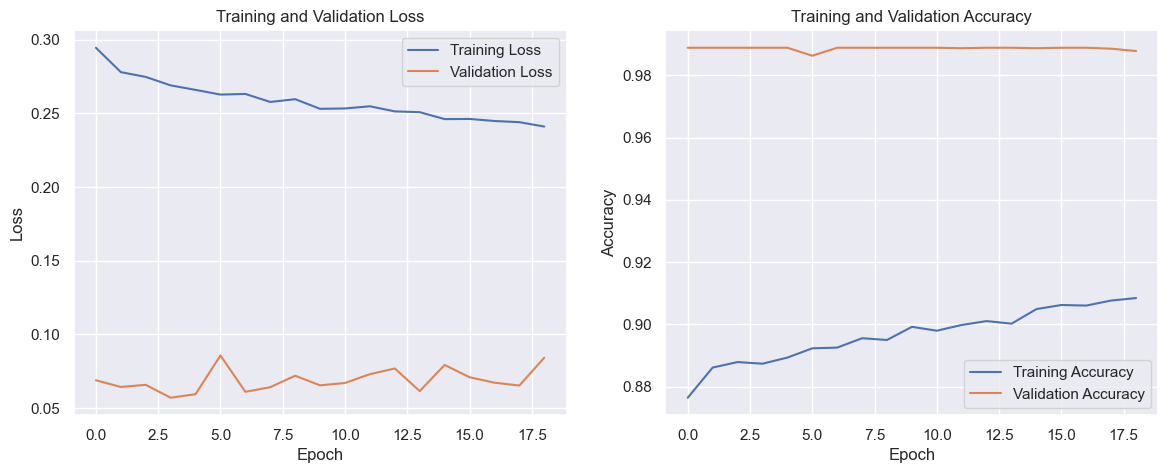

In [21]:
import matplotlib.pyplot as plt

# 绘制损失曲线
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# 绘制准确率曲线
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()


In [22]:
###查看訓練集預測結果
from sklearn.model_selection import train_test_split
y_pred_proba = model.predict(X_train)
y_pred = np.argmax(y_pred_proba, axis=1)
unique, counts = np.unique(y_pred, return_counts=True)
class_counts = dict(zip(unique, counts))
print("y_train (Class 0):", class_counts.get(0, 0))  # 获取类别0的数量，如果没有则返回0
print("y_train (Class 1):", class_counts.get(1, 0))  # 获取类别1的数量，如果没有则返回0


1036/1036 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step
y_train (Class 0): 28148
y_train (Class 1): 5004


In [23]:
y_pred_train = np.array(np.argmax(model.predict(X_train), axis=1))[...,np.newaxis]
y_pred_train.shape

1036/1036 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step


(33152, 1)

In [24]:
from sklearn.metrics import accuracy_score
train_accuracy = accuracy_score(y_train, y_pred_train)
print(f"Accuracy on train set: {train_accuracy * 100:.2f}%")


Accuracy on train set: 92.94%


In [25]:
#####查看驗證集訓練結果
y_pred_train = np.array(np.argmax(model.predict(X_train), axis=1))[...,np.newaxis]
y_pred_train.shape
# 假设 X_train 和 y_train_oh 是原始的训练数据和标签
# 重新分割数据以创建与训练时相同的训练集和验证集
X_train_part, X_val, y_train_part, y_val = train_test_split(
    X_train, y_train_oh, test_size=0.2  
)

# 使用模型对验证集进行预测
y_pred_proba_val = model.predict(X_val)
y_pred_val = np.argmax(y_pred_proba_val, axis=1)

# 计算每个类别的数量
unique_val, counts_val = np.unique(y_pred_val, return_counts=True)
class_counts_val = dict(zip(unique_val, counts_val))

# 打印每个类别的计数
print("y_val (Class 0):", class_counts_val.get(0, 0))  # 获取类别0的数量，如果没有则返回0
print("y_val (Class 1):", class_counts_val.get(1, 0))  # 获取类别1的数量，如果没有则返回0


1036/1036 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step
y_val (Class 0): 5628
y_val (Class 1): 1003


In [26]:
# 从 history 对象中获取验证集上的准确度历史
val_accuracy = history.history['val_accuracy']
print(f"Validation Accuracy: {max(val_accuracy) * 100:.2f}%")


Validation Accuracy: 98.88%


In [27]:
y_pred_proba = model.predict(X_test)
y_pred = np.argmax(y_pred_proba, axis=1)
unique, counts = np.unique(y_pred, return_counts=True)
class_counts = dict(zip(unique, counts))
print("y_test (Class 0):", class_counts.get(0, 0))  # 获取类别0的数量，如果没有则返回0
print("y_test (Class 1):", class_counts.get(1, 0))  # 获取类别1的数量，如果没有则返回0


183/183 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
y_test (Class 0): 3451
y_test (Class 1): 2374


In [28]:
y_pred_test = np.array(np.argmax(model.predict(X_test), axis=1))[...,np.newaxis]
y_pred_test.shape

183/183 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


(5825, 1)

In [29]:
test_accuracy = accuracy_score(y_test, y_pred_test)
print(f"Accuracy on train set: {test_accuracy * 100:.2f}%")
#epoch16 = test_accuracy 75.95% , epoch22 = test_accuracy 75.95%  epoch19= test_accuracy 76.71%

Accuracy on train set: 76.17%
